In [32]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal


def forward(loga, logb, T, logpi, observations):
    logalpha = np.empty((T, 4))
    for i in range(4):
        logalpha[0, i] = logpi[i] + logb[0, i]
    for t in range(1, T):
        for j in range(4):
            logterms = [loga[i, j] + logalpha[t - 1, i] for i in range(4)]
            logalpha[t, j] = np.logaddexp.reduce(logterms) + logb[t, j]
        
    return logalpha

def backward(loga, logb, T):
    logbeta = np.empty((T, 4))
    logbeta[T - 1, :] = 0
    for t in range(T - 2, -1, -1):
        for i in range(4):
            logterms = [loga[i, j] + logb[t + 1, i] + logbeta[t + 1, j] for j in range(4)]
            logbeta[t, i] = np.logaddexp.reduce(logterms)
            
    return logbeta

def compute_gamma(logalpha, logbeta, T):
    loggamma = np.empty((T, 4))
    for t in range(T):
        for i in range(4):
            loggamma[t, i] = logalpha[t, i] + logbeta[t, i] - np.logaddexp.reduce([
                logalpha[t, j] + logbeta[t, j] for j in range(4)
            ])

    return loggamma

def compute_xi(logalpha, logbeta, loga, logb, observations, T):
    xi = np.empty((T, 4, 4))
    for t in range(T - 1):
        for i in range(4):
            for j in range(4):
                logterms = []
                for k in range(4):
                    for l in range(4):
                        logterms.append(
                            logalpha[t, k] + loga[k, l] + logb[t + 1, l] + logbeta[t + 1, l]
                        )
                xi[t, i, j] = (
                    logalpha[t, i] + loga[i, j] + logb[t + 1, j] + logbeta[t + 1, j]
                    - np.logaddexp.reduce(logterms)
                )
    return xi

def compute_a(loggamma, logxi, T):
    loga = np.empty((4, 4))
    for i in range(4):
        for j in range(4):
            loga[i, j] = (
                np.logaddexp.reduce([logxi[t, i, j] for t in range(T - 1)])
                - np.logaddexp.reduce([loggamma[t, i] for t in range(T - 1)])
            )
    return loga


def compute_b(mus, Sigmas, dataset, T):
    """
    mus: M x N mean returns (over time) per regime and asset
    Sigmas: M x N x N the covariance matrix per regime
    dataset: T x N matrix of returns

    returns: logB, T x M, where logB[t,k] = log p(r_t | s_t = k)
    """

    logb = np.empty((T, 4))
    for t in range(T):
        for k in range(4):
            # if np.isnan(dataset[t, :]).any() or np.isnan(mus[k, :]).any() or np.isnan(Sigmas[k, :, :]).any():
            #     raise AssertionError()
            logb[t, k] = multivariate_normal.logpdf(dataset[t, :], mus[k, :], Sigmas[k, :, :])
    return logb


def compute_mus_sigmas(loggamma, dataset, T, eps=1e-04):
    mus = np.empty((4, 2))
    Sigmas = np.empty((4, 2, 2))
    for m in range(4):
        exp_gammas = np.empty(T)

        # compute mus
        exp_gammas = np.exp(loggamma[:, m])
        den = exp_gammas.sum()
        if den < eps:
            # state got no responsibility -> reinitialize it
            mus[m, :] = np.mean(dataset, axis=0) + np.random.normal(0, 0.01, size=2)
            Sigmas[m, :, :] = np.cov(dataset.T) + eps * np.eye(2)
            continue
        
        mus[m, :] = np.sum(exp_gammas[:, None] * dataset, axis=0) / den

        # compute Sigmas
        diffs = dataset - mus[m, :]
        Sigmas[m, :, :] = (diffs.T @ (diffs * exp_gammas[:, None])) / den

        # stabilize
        Sigmas[m, :, :] = (Sigmas[m, :, :] + Sigmas[m, :, :].T) / 2
        Sigmas[m, :, :] += eps * np.eye(2)

    return mus, Sigmas


def viterbi(logpi, logb, loga, observations, T):
    logdelta = np.zeros((T, 4))
    psi = np.zeros((T, 4))
    # logdelta[t, j] = log probability of the best path ending in state j at time t
    # psi[t, j] = state that maximizes prob of having been there, over all seq
    # ended in j at time t
    logdelta[0, :] = logpi + logb[0, :]
    for t in range(1, T):
        for j in range(4):
            seq_probs = logdelta[t - 1, :] + loga[:, j]
            logdelta[t, j] = np.max(seq_probs) + logb[t, j]
            psi[t, j] = np.argmax(seq_probs)

    states = np.zeros(T, dtype=int) # holds most likely states for each time
    states[-1] = np.argmax(logdelta[-1, :])
    p = np.max(logdelta[-1, :]) # highest probability over all states (ended in T)

    for t in range(T - 2, -1, -1):
        states[t] = psi[t + 1, states[t + 1]]
        # S_{T-1}=argmax over all j of (logdelta[T - 1, j])

    return states, p

def match_states_by_B(B_est, B_true):
    # cost = L2 distance between emission distributions (rows)
    cost = cdist(B_est, B_true, metric='euclidean')  # shape (N_est, N_true)
    row_ind, col_ind = linear_sum_assignment(cost)
    # row_ind[i] -> col_ind[i], we want a permutation array perm where perm[est_index] = true_index
    perm = np.empty(B_est.shape[0], dtype=int)
    perm[row_ind] = col_ind
    return perm

def permute_model(pi, A, mus, Sigmas, perm):
    M = len(perm)
    pi_r = np.zeros_like(pi)
    A_r = np.zeros_like(A)
    mus_r = np.zeros_like(mus)
    Sigmas_r = np.zeros_like(Sigmas)
    # perm[est_i] = true_i
    for est_i, true_i in enumerate(perm):
        pi_r[true_i] = pi[est_i]
    for est_i, true_i in enumerate(perm):
        for est_j, true_j in enumerate(perm):
            A_r[true_i, true_j] = A[est_i, est_j]
    for est_i, true_i in enumerate(perm):
        mus_r[true_i] = mus[est_i]
        Sigmas_r[true_i] = Sigmas[est_i]
    return pi_r, A_r, mus_r, Sigmas_r

def kl_gaussian(mu0, S0, mu1, S1, eps=1e-8):
    # KL(N0 || N1)
    d = mu0.shape[0]
    # regularize
    S0 = S0 + eps * np.eye(d)
    S1 = S1 + eps * np.eye(d)
    invS1 = np.linalg.inv(S1)
    diff = (mu1 - mu0).reshape(-1, 1)
    term_trace = np.trace(invS1 @ S0)
    term_quad = float(diff.T @ invS1 @ diff)
    # sign and natural log of determinant
    sign0, logdet0 = np.linalg.slogdet(S0)
    sign1, logdet1 = np.linalg.slogdet(S1)
    logdet_ratio = logdet1 - logdet0
    return 0.5 * (term_trace + term_quad - d + logdet_ratio)

def sym_kl(mu0, S0, mu1, S1, eps=1e-8):
    return kl_gaussian(mu0, S0, mu1, S1, eps) + kl_gaussian(mu1, S1, mu0, S0, eps)

def match_states_by_gaussians(mus_est, Sigmas_est, mus_true, Sigmas_true, eps=1e-8):
    M = mus_est.shape[0]
    cost = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            cost[i, j] = sym_kl(mus_est[i], Sigmas_est[i], mus_true[j], Sigmas_true[j], eps)
    row_ind, col_ind = linear_sum_assignment(cost)
    # build perm such that perm[est_i] = true_j
    perm = np.zeros(M, dtype=int)
    for r, c in zip(row_ind, col_ind):
        perm[r] = c
    return perm


In [33]:
import numpy as np

T = 200
T_test = 100

A_std_noise = 0.05
pi_std_noise = 0.05
mus_std_noise = [2.0, 0.5] # temp, rain level
Sigmas_std_noise = 0.02

# columns and rows indexed by
# (warm & rain, warm & dry, cold & rain, cold & dry)

# M x M
A_real = np.array([
    [0.6, 0.3, 0.05, 0.05],
    [0.2, 0.7, 0.05, 0.05],
    [0.1, 0.1, 0.7, 0.1],
    [0.05, 0.05, 0.2, 0.7]
    ], dtype=np.float32)

# M x N
mus_real = np.array([
    [20, 5],    # Warm & Rain
    [22, 0],    # Warm & Dry
    [5, 7],     # Cold & Rain
    [3, 0]      # Cold & Dry
], dtype=np.float32)

# M x N x N
Sigma_real = np.array([
    [[3, 0], [0, 2]],
    [[2, 0], [0, 1]],
    [[4, 0], [0, 3]],
    [[3, 0], [0, 1]]
], dtype=np.float32)

# M
pi_real = np.full(4, 0.25)

observations_total = np.zeros((T + T_test, 2))
states_total = np.zeros(T + T_test, dtype=int)

states_total[0] = np.random.choice(4)
observations_total[0, :] = np.random.multivariate_normal(mus_real[states_total[0], :], Sigma_real[states_total[0], :, :])

for t in range(1, T + T_test):
    # sample next state according to transition probabilities from A_real
    states_total[t] = int(np.random.choice(4, p=A_real[states_total[t-1], :]))
    observations_total[t] = np.random.multivariate_normal(mus_real[states_total[t], :], Sigma_real[states_total[t], :, :])

# split data in training and testing set
observations_train = observations_total[:T, :]
observations_test = observations_total[T:, :]
states_train = states_total[:T]
states_test = states_total[T:]

log_B_real = compute_b(mus_real, Sigma_real, observations_train, T)
B_real = np.exp(log_B_real)
print('b real:'); print(B_real)

print('states:'); print(states_total)
print()
print('observations:'); print(observations_total)

b real:
[[7.75671875e-07 3.62531260e-02 3.15828736e-25 3.73694223e-32]
 [4.80055646e-06 5.24738580e-02 5.04361318e-21 5.88251252e-26]
 [1.50893878e-05 7.53304834e-02 1.27600425e-20 7.15954124e-26]
 [1.23720848e-04 9.19401380e-02 1.28360999e-19 1.69652666e-25]
 [8.00802896e-06 6.26888909e-02 7.60616399e-21 6.50783157e-26]
 [2.38613070e-04 9.05711150e-02 3.77249678e-21 1.13345123e-28]
 [3.93270392e-04 3.53165637e-02 2.55695662e-22 1.60155644e-31]
 [3.96174125e-03 1.74999721e-02 1.57207219e-17 3.66888630e-25]
 [3.01894375e-04 8.19932156e-02 3.84145608e-21 7.07409594e-29]
 [3.22272838e-04 8.19717566e-02 3.22685637e-19 1.54813855e-25]
 [1.56582934e-23 3.56182158e-37 7.56268553e-06 7.86791501e-02]
 [3.36046327e-05 9.84809592e-02 1.04939036e-22 6.14338665e-30]
 [3.81139832e-04 8.42899177e-02 1.59611849e-19 3.45316250e-26]
 [7.68394558e-05 7.51635321e-02 3.09840273e-19 1.43324348e-24]
 [8.06722417e-05 9.76742776e-02 5.02125767e-20 6.97813020e-26]
 [2.01126205e-06 3.91855509e-02 1.42929784e-25 

In [34]:
pct_change_ll_tol = 0.01
n_attempts = 100
max_attempt_per_iter = 10

# these will store data from every run
# structure: list of lists (inner list = data per iteration)
ll_list = []
diff_norms_A = []
diff_norms_B = []
diff_norms_pi = []

# these will store data from every run
# stucture: list of floats (one per attempt, not one per iteration)
pct_states_matched_viterbi = []
frac_correct_states_predicted_list = []
frac_correct_obs_predicted_list = []

# initialize parameters for estimation (pretend we don't know the true values)
A = A_real.copy()
pi = pi_real.copy()

for attempt in range(n_attempts):

    prev_ll = 1.0
    log_ll = 2.0
    
    # add noise to A
    A += np.random.normal(0, A_std_noise, (4, 4))
    A = np.clip(A, a_min=0.05, a_max=0.95)
    A_rowsum = A.sum(axis=1)
    for i in range(4):
        A[:, i] /= A_rowsum
    loga = np.log(A)

    # add noise to pi
    pi += np.random.normal(0, pi_std_noise, 4)
    pi = np.clip(pi, a_min=0.05, a_max=0.95)
    pi /= pi.sum()
    logpi = np.log(pi)

    # add noise to mus
    mus = np.empty(mus_real.shape)
    mus[:, 0] = np.clip(mus_real[:, 0] + np.random.normal(0, mus_std_noise[0], size=4), a_min=0, a_max=30)
    mus[:, 1] = np.clip(mus_real[:, 1] + np.random.normal(0, mus_std_noise[1], size=4), a_min=0, a_max=30)
    # add noise to Sigma
    Sigma = Sigma_real.copy()
    for m in range(4):
        Sigma[m, :, :] = np.clip(Sigma_real[m, :, :] + Sigmas_std_noise * np.eye(2), a_min=0, a_max=10)

    # compute logB
    logb = compute_b(mus, Sigma, observations_train, T)

    # store some metrics for each iterion step
    this_diff_norms_A = []
    this_diff_norms_B = []
    this_diff_norms_pi = []
    this_attempt_ll_list = []

    this_attempt_count = 0

    while abs(prev_ll - log_ll) / prev_ll > pct_change_ll_tol and this_attempt_count < max_attempt_per_iter:
        prev_ll = log_ll

        # E step
        logalpha = forward(loga, logb, T, logpi, observations_train)
        logbeta = backward(loga, logb, T)
        loggamma = compute_gamma(logalpha, logbeta, T)
        logxi = compute_xi(logalpha, logbeta, loga, logb, observations_train, T)

        # M step
        loga = compute_a(loggamma, logxi, T)
        mus, Sigmas = compute_mus_sigmas(loggamma, observations_train, T)
        logb = compute_b(mus, Sigmas, observations_train, T)
        logpi = loggamma[0, :]

        # storing metrics for each iteration
        log_ll = np.logaddexp.reduce(logalpha[-1, :])
        this_attempt_ll_list.append(log_ll)
        this_diff_norms_A.append(np.linalg.norm(np.exp(loga) - A_real))
        this_diff_norms_B.append(np.linalg.norm(np.exp(logb) - B_real))
        this_diff_norms_pi.append(np.linalg.norm(np.exp(logpi) - pi_real))

        this_attempt_count += 1

    A = np.exp(loga)
    A /= A.sum(axis=1, keepdims=True)
    B = np.exp(logb)
    B /= B.sum(axis=1, keepdims=True)
    pi = np.exp(logpi)
    pi /= pi.sum()

    A = np.clip(A, 1e-10, 1)
    B = np.clip(B, 1e-10, 1)

    # store data from this attempt
    ll_list.append(this_attempt_ll_list)
    diff_norms_A.append(this_diff_norms_A)
    diff_norms_B.append(this_diff_norms_B)
    diff_norms_pi.append(this_diff_norms_pi)

    # test model on training data

    # first, use the Hungarian method to match the most likely B_real orientation, given the
    # orientation of B
    perm = match_states_by_gaussians(mus, Sigma, mus_real, Sigma_real)
    pi_p, A_p, mus_p, Sigma_p = permute_model(pi, A, mus, Sigma, perm)
    print('pi p, A p, mus & sigmas:'); print(pi_p); print(A_p); print(mus); print(Sigma)

    logpi_p = np.log(pi_p)
    loga_p = np.log(A_p)
    logb_p = compute_b(mus_p, Sigma_p, observations_train, T)

    # assuming we have access to the future observations, we will test the model using the viterbi path
    # algorithm, to see how well it can predict the hidden state variables, given these observations
    predicted_states_vit, p = viterbi(logpi_p, logb_p, loga_p, observations_test, T_test)
    pct_matched = 1 - np.count_nonzero(np.logical_xor(predicted_states_vit, states_test)) / len(predicted_states_vit)
    pct_states_matched_viterbi.append(pct_matched)

    # assuming we are at time T and we wanted to predict the future states and observations up untill
    # t = T_test, we will try to predict these values and see how well the model generalizes
    predicted_obs = np.empty((T_test, 2))
    predicted_states = np.empty(T_test, dtype=int)

    B_p = np.exp(logb_p)
    states_p_dist = np.exp(loggamma[-1, :])
    predicted_states[0] = np.argmax(states_p_dist)
    predicted_obs[0] = np.argmax(B_p[predicted_states[0], :])

    # generate prediction states and observations using A and B
    for k in range(1, T_test):

        # prediction of states
        states_p_dist = states_p_dist @ A_p
        states_p_dist /= states_p_dist.sum()
        predicted_states[k] = np.argmax(states_p_dist)
        # determine the predicted observation by taking the most likely observation, given the
        # predicted state value
        predicted_obs[k, :] = pi @ mus

    # save the fraction of correctly predicted states and observations
    frac_correct_states_predicted = 1 - np.count_nonzero(np.logical_xor(states_test, predicted_states)) / len(predicted_states)
    frac_correct_obs_predicted = 1 - np.count_nonzero(np.logical_xor(observations_test, predicted_obs)) / len(predicted_obs)

    frac_correct_states_predicted_list.append(frac_correct_states_predicted)
    frac_correct_obs_predicted_list.append(frac_correct_obs_predicted)


C:\Users\tobia\AppData\Local\Temp\ipykernel_22940\4134331874.py:170: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  term_quad = float(diff.T @ invS1 @ diff)


pi p, A p, mus & sigmas:
[7.74720539e-015 1.00000000e+000 8.68663250e-044 8.42451153e-104]
[[6.67023839e-01 2.21189976e-01 6.72179031e-02 4.45682812e-02]
 [1.96851325e-01 6.83337534e-01 9.33556889e-02 2.64554524e-02]
 [6.95958906e-02 7.20436915e-02 7.85055404e-01 7.33050138e-02]
 [3.41589618e-04 2.56047781e-02 3.30933465e-01 6.43120167e-01]]
[[20.5888926   4.41159437]
 [22.12552682  0.1817423 ]
 [ 6.68027397  5.06682662]
 [ 3.07616878  0.09152142]]
[[[3.02 0.  ]
  [0.   2.02]]

 [[2.02 0.  ]
  [0.   1.02]]

 [[4.02 0.  ]
  [0.   3.02]]

 [[3.02 0.  ]
  [0.   1.02]]]
pi p, A p, mus & sigmas:
[5.16437997e-015 1.00000000e+000 1.48781295e-043 1.86837159e-125]
[[6.74144369e-01 2.20784365e-01 6.05164358e-02 4.45548296e-02]
 [1.88668727e-01 6.87684195e-01 1.10716932e-01 1.29301463e-02]
 [6.81693103e-02 7.06085200e-02 8.12787785e-01 4.84343848e-02]
 [2.29462975e-08 2.48398286e-02 3.25603709e-01 6.49556440e-01]]
[[20.57343982  4.4429729 ]
 [22.13219752  0.17385563]
 [ 6.45421676  4.93213449]
 [

Plot the log-likelyhood values of each attempt

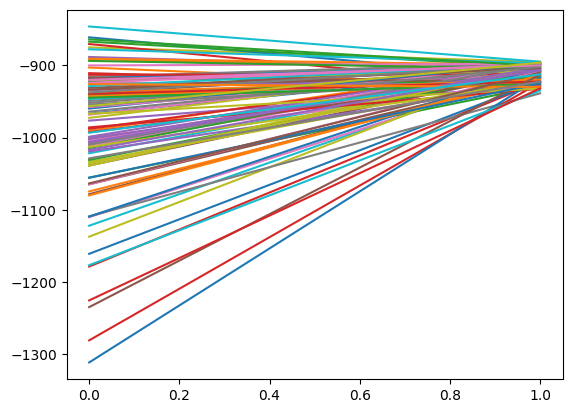

In [35]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(n_attempts):
    ax.plot(list(range(len(ll_list[i]))), ll_list[i])

plt.show()

Plot the Frobenius norm indicating the error between the real value and the estimated value for the matrices $A$, $B$ and $\pi$

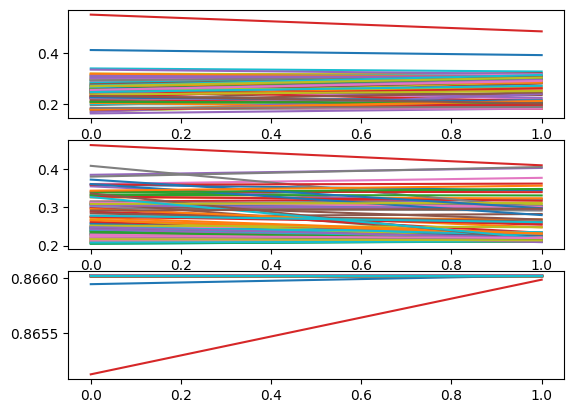

[[np.float64(0.25049804801500186), np.float64(0.28659801672771973)], [np.float64(0.31601346368573396), np.float64(0.3162872256219204)], [np.float64(0.24643014699030114), np.float64(0.290375807446187)], [np.float64(0.23847372520545418), np.float64(0.2898816294426055)], [np.float64(0.1625776982554684), np.float64(0.18209169792141788)], [np.float64(0.21908164628391938), np.float64(0.20117347256758564)], [np.float64(0.2590573220217606), np.float64(0.28691084587879007)], [np.float64(0.19529022909813842), np.float64(0.23986707250094766)], [np.float64(0.27012505266251163), np.float64(0.30036110671334254)], [np.float64(0.34042778804606344), np.float64(0.32823473120386415)], [np.float64(0.2430108419141197), np.float64(0.29315039531371456)], [np.float64(0.26604096209252037), np.float64(0.2994279078399809)], [np.float64(0.2996502355005483), np.float64(0.30904426612219166)], [np.float64(0.22491992888299572), np.float64(0.18064052877616432)], [np.float64(0.27128515490875044), np.float64(0.299532558

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3)

for i in range(n_attempts):
    ax1.plot(diff_norms_A[i])
    ax2.plot(diff_norms_B[i])
    ax3.plot(diff_norms_pi[i])
plt.show()

Make a bar chart out of the fraction of correctly predicted states, given the true observations from $t=T_{\text{test}}$ onwards

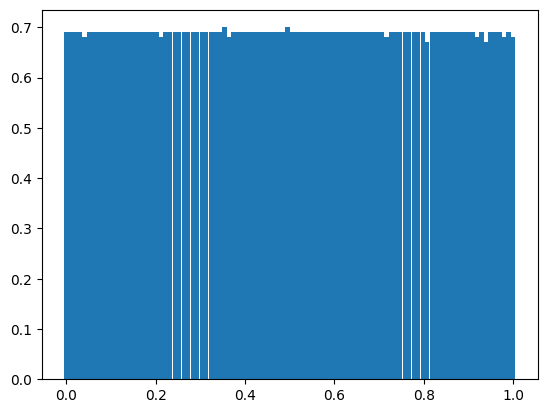

maximum pct correct: 0.7 from attempt 36
minimum pct correct: 0.6699999999999999 from attempt 81


In [37]:
plt.bar(np.linspace(0, 1, n_attempts), pct_states_matched_viterbi, width=1/(1 + n_attempts))
plt.show()

print('maximum pct correct:', np.max(pct_states_matched_viterbi), 'from attempt', np.argmax(pct_states_matched_viterbi) + 1)
print('minimum pct correct:', np.min(pct_states_matched_viterbi), 'from attempt', np.argmin(pct_states_matched_viterbi) + 1)